# Example Preprocessing Pipeline using MNE-Python and .xdf-files

This notebook serves as an example on how to perform preprocessing steps for multiple subjects using the mne-python library. The pre-processing pipeline consists of x steps and are depicted in the figure below.

<img src="resources/methods-preprocessing-pipeline.png" width="800" height="400">

## 0. Familiarization with the data and the paradigm

Please familiarize yourself with the provided data and the paradigm. Therefore, have a look at chapters ***2.1 Experimental Design*** and ***2.2 Pre-processing*** of the [Decoding_of_range_thesis.pdf](resources/decoding_of_range_thesis.pdf). There you will also find background information and references for the performed pre-processing steps.

## 1. Imports and constants
First, we import the necessary modules and define constants that are used throughout the preprocessing.
Helper functions are declared in the package utils.py and are imported as ut.

In [7]:
import mne
import time
import numpy as np
from tqdm import tqdm

# Import self-written modules
import xdf_to_fif_converter as xtfc
import preprocessing_ptu as prep
import file_handling as fh

The ***DATA_PATH*** needs to be specified to your local directory.

In [8]:
DATA_PATH = 'D:/Diplomarbeit_data/eeg/' # relative path to the data folder

In [9]:
SUBJECTS = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A09', 'A10'] # subject names
TRIAL_TYPE_MARKERS = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l'] # name of the markers of interest
IS_SAVE = False # Flag to determine wheter to save the preprocessed data:
mne.set_log_level('WARNING') #'INFO' 'WARNING'

## 2. XDF --> FIF
The following cell reads all xdf-files containing the raw eeg and markers and loads them into the mne structure and optionally stores them as .fif-files. This function also performs some cleaning of the markers. Feel free to have a closer look in the ***xdf_to_fif_converter.py*** file.

It uses the custom function ***xdf_to_fif***, which takes the source path and the destination path as parameters:

In [4]:
help(xtfc.xdf_to_fif)

Help on function xdf_to_fif in module xdf_to_fif_converter:

xdf_to_fif(src, dst, sbj, store=True)
    Convert .xdf files to .fif files for a given subject.
    
    :param src: str, path of the folder containing .xdf files.
    :param dst: str, path of the folder where to save the .fif files.
    :param sbj: str, subject identifier.



In [10]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='raw', dst_fldr='raw_fif')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Extracting subject {subject}', end=' ')

    # Call the xdf_to_fif function from the xtfc module which takes care of converting the xdf files to fif files:
    xtfc.xdf_to_fif(src_path, dst_path, subject, store=IS_SAVE)

    print()

print(f'Finished reading, took me {round(time.time()-start)} seconds...')

Extracting subject A01 # # # # # # # # # # # 
Extracting subject A02 # # # # # # # # # # # 
Extracting subject A03 # # # # # # # # # # # 
Extracting subject A04 # # # # # # # # # # # 
Extracting subject A05 # # # # # # # # # # # 
Extracting subject A06 # # # # # # # # # # # 
Extracting subject A07 # # # # # # # # # # # 
Extracting subject A08 # # # # # # # # # # # 
Extracting subject A09 # # # # # # # # # # # 
Extracting subject A10 # # # # # # # # # # # 
Finished reading, took me 48 seconds...


## 3. Concatenate all fif files for each subject

Now that all files are converted to an mne readable structure, the runs of each participant are concatenated. On total there were 9 runs per participant. Concatinating the runs at the beginning simplifies the file handling as it reduces 90 individual .fif files to 10 individual .fif files.

For this, the function ***concat_fifs*** from the ***preprocessing_ptu.py*** file is used.

In [6]:
help(prep.concat_fifs)

Help on function concat_fifs in module preprocessing_ptu:

concat_fifs(src, dst, sbj, paradigm='paradigm', store=True)
    Concatenates multiple raw.fif files from a single subject and paradigm.
    
    :param src: str, path to the directory containing the input raw.fif files.
    :param dst: str, path to the directory where the concatenated raw.fif file will be stored.
    :param sbj: str, subject name contained in the file names.
    :param paradigm: str, paradigm name contained in the file names (default is 'paradigm').
    :return: None
    
    - Searches for all the files in the source directory containing the subject name, 'raw.fif' and the specified
     paradigm.
    - Reads each of the selected raw.fif files using MNE-Python's read_raw function.
    - Concatenates the read files into a single raw object using MNE-Python's concatenate_raws function.
    - Saves the concatenated raw object as a new raw.fif file in the destination directory.



In [ ]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='raw_fif', dst_fldr='concat')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Reading all fif files for subject {subject}', end=' ')

    # Concatenate all raw files for the paradigm and the eye paradigm:
    prep.concat_fifs(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE)
    #prep.concat_fifs(src=src_path, dst=dst_path, sbj=subject, paradigm='eye', store=False)
    print()

print(f'Finished concatenating, took me {round(time.time() - start)} seconds...')

Reading all fif files for subject A01 # # 

Visualize the EEG for a specific subject

In [6]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='concat', dst_fldr='temp')

sbj_to_vis = 'A01'

# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

## 4. Filter  the data (HP 0.4 Hz and Notch 50 Hz)

Now the real preprocessing begins. The concatenated EEG is first highpass filtered with an 8th-order zero-phase Butterworth filter
at a cutoff frequency of 0.4 Hz to remove low-frequency artifacts such as sweat or motion artifacts. Afterwards, a notch filter is applied to suppress the 50Hz line noise. This filter was implemented as a steep band-stop filter (zero-phase Butterworth 16th order) with a lower cutoff frequency of 49.38 Hz and an upper cutoff frequency of 50.62 Hz. 

The filtering is handled by the ***filter_fifs*** function. Feel free to modify this function and try different filter designs and cut-off frequencies.

Observe how the spectra change when tuning the filter parameters.

In [9]:
help(prep.filter_fifs)

Help on function filter_fifs in module preprocessing_ptu:

filter_fifs(src, dst, sbj, paradigm='paradigm', store=True, show_fft=True)
    Applies highpass and notch filters to a single raw EEG data file, and saves the filtered data in a new file.
    
    :param src: The directory path containing the original raw EEG data file.
    :type src: str
    
    :param dst: The directory path where the filtered EEG data file will be stored.
    :type dst: str
    
    :param sbj: The subject identifier for the raw EEG data file.
    :type sbj: str
    
    :param paradigm: The task identifier for the raw EEG data file. Default is 'paradigm'.
    :type paradigm: str
    
    :return: None
    :rtype: None



Filtering raw EEG for subject A01


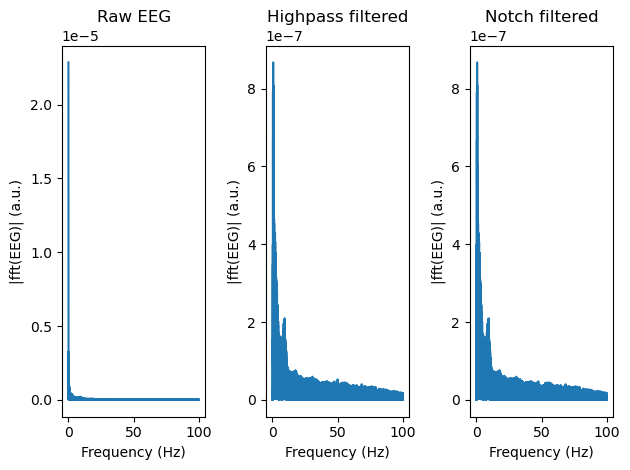

Filtering raw EEG for subject A02


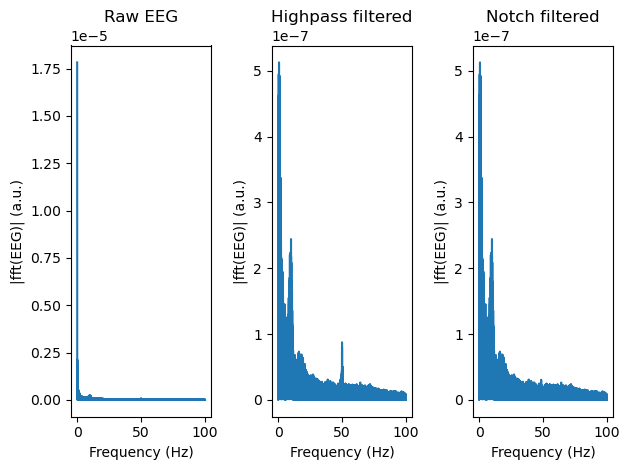

Filtering raw EEG for subject A03


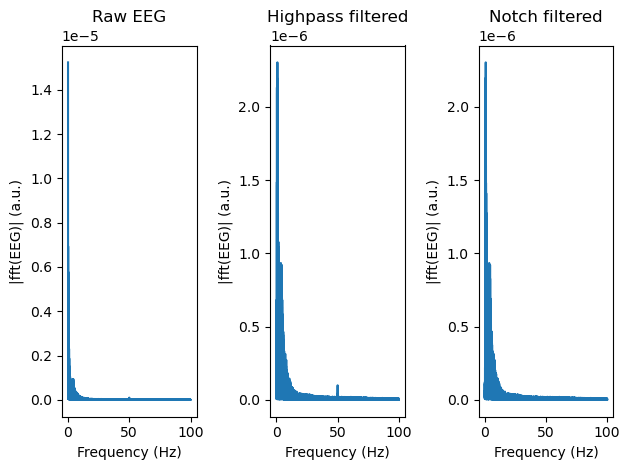

Filtering raw EEG for subject A04


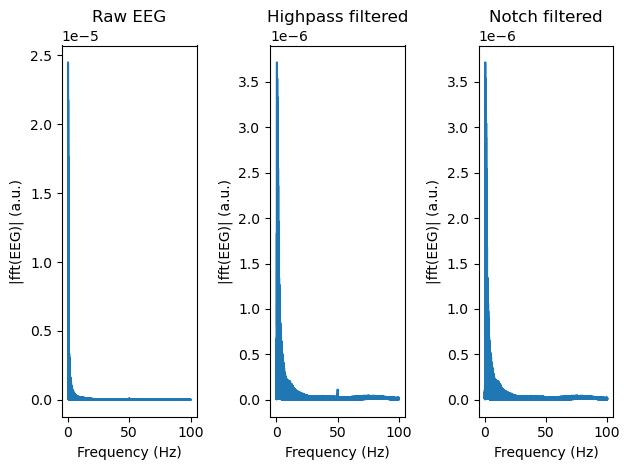

Filtering raw EEG for subject A05


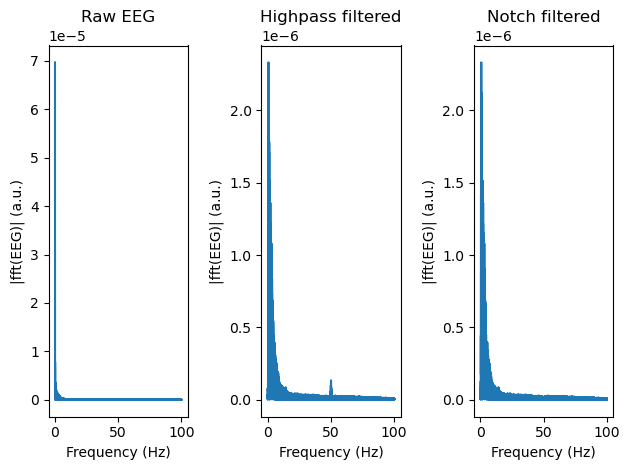

Filtering raw EEG for subject A06


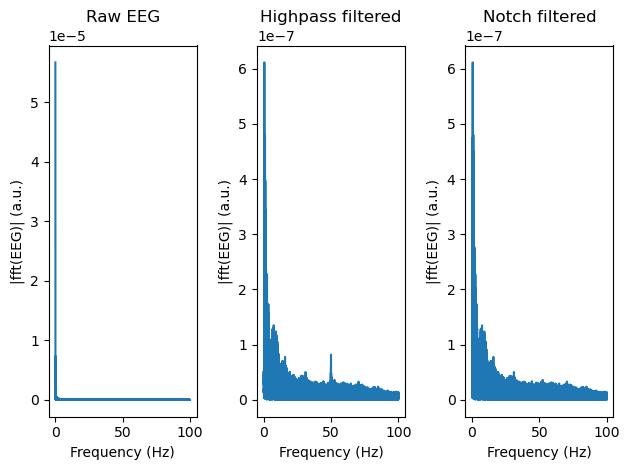

Filtering raw EEG for subject A07


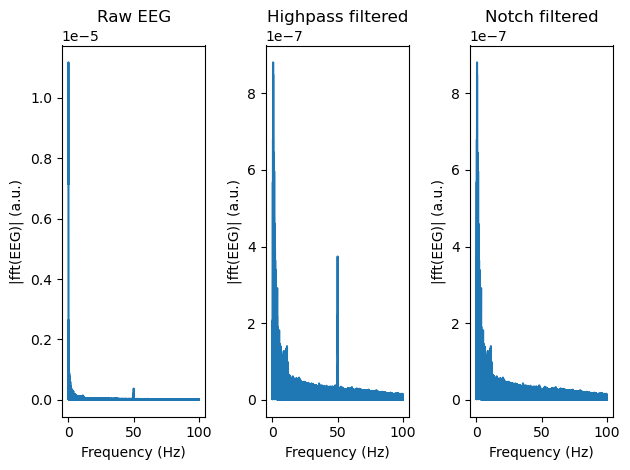

Filtering raw EEG for subject A08


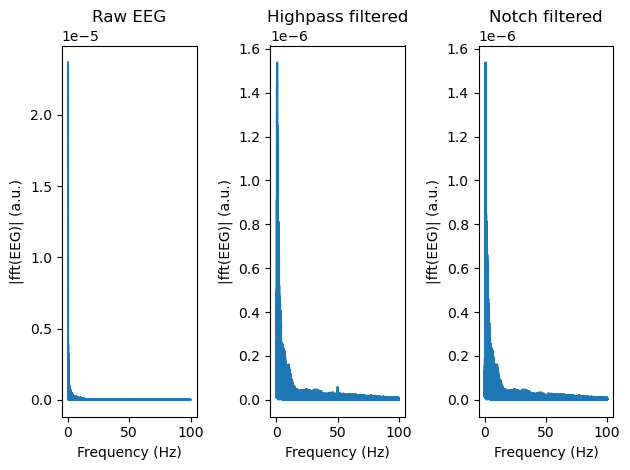

Filtering raw EEG for subject A09


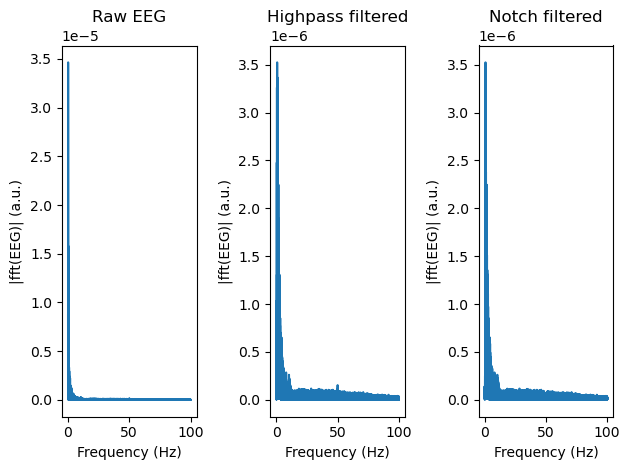

Filtering raw EEG for subject A10


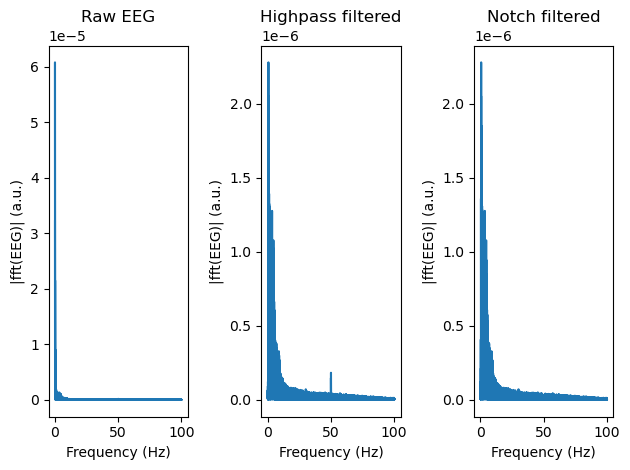

Finished filtering, took me 47 seconds...


In [5]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='concat', dst_fldr='filtered')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Filtering raw EEG for subject {subject}')

    # Concatenate all raw files for the paradigm and the eye paradigm:
    prep.filter_fifs(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE, show_fft=True)

print(f'Finished filtering, took me {round(time.time() - start)} seconds...')

Visualize the EEG and observed what changed

In [6]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='filtered', dst_fldr='temp')

sbj_to_vis = 'A01'

# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

## 5. Interpolate bad channels

In this cell the bad channels are interpolated based on visual inspection. The visual inspection was performed prior and the channels are stored in ***/dataframes/bad_channels.csv*** feel free to use them.

In [12]:
help(prep.interpolate_bads)

Help on function interpolate_bads in module preprocessing_ptu:

interpolate_bads(src, dst, sbj, paradigm='paradigm', store=True)
    Interpolates bad channels in the raw data file for a given subject and saves the interpolated raw file.
    
    :param src: The path to the directory containing the raw data files.
    :type src: str
    :param dst: The path to the directory where the interpolated raw file will be saved.
    :type dst: str
    :param sbj: The subject identifier for the data file to be interpolated.
    :type sbj: str
    :param paradigm: The paradigm identifier for the data file to be interpolated. Default is 'paradigm'.
    :type paradigm: str
    :return: None



In [13]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='filtered', dst_fldr='bad_ch_interpolated')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Interpolating bad channels for subject {subject}')

    # Interpolate bad channels for all raw files for the paradigm:
    prep.interpolate_bads(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE)

print(f'Finished interpolating, took me {round(time.time() - start)} seconds...')

Interpolating bad channels for subject A01
['PO8', 'T8', 'O1', 'PO4', 'TP8', 'Pz']
Interpolating bad channels for subject A02
['PO10', 'TP8', 'T7', 'FC3', 'PO4']
Interpolating bad channels for subject A03
['PO3']
Interpolating bad channels for subject A04
['T7', 'PO10', 'T8', 'Fp1', 'Fp2', 'AF7']
Interpolating bad channels for subject A05
['O1', 'P6', 'Oz', 'AF7', 'Fp1', 'Fp2', 'PO7', 'T8', 'O2', 'AF3', 'AF4', 'AF8']
Interpolating bad channels for subject A06
['FCz', 'Oz', 'F7', 'TP7', 'PO9', 'O1']
Interpolating bad channels for subject A07
['T7', 'T8', 'FT8', 'FC6', 'C6', 'P8']
Interpolating bad channels for subject A08
['T7', 'T8', 'FT8', 'C5']
Interpolating bad channels for subject A09
['T8', 'AF8', 'AF3', 'Fp1', 'Fp2', 'PO3']
Interpolating bad channels for subject A10
['PO7', 'T8', 'O1', 'PO9', 'T7', 'Oz', 'O2', 'PO8']
Finished interpolating, took me 16 seconds...


Visualize the EEG and observed what changed

In [14]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='bad_ch_interpolated', dst_fldr='temp')

sbj_to_vis = 'A01'

# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

## 6. Eyesubtraction

The following cells apply the SGEYESUB algorithm by [Kobler et al.](https://github.com/rkobler/eyeartifactcorrection) to the EEG data. The algorithm was applied using MATLAB and the matrices were stored and are multiplicated to the corresponding subjects' EEG data in the following cell.

In [15]:
# Apply the eyesub matrices:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='bad_ch_interpolated', dst_fldr='eyesubed')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Fitting eye subtraction for subject {subject}')

    # Interpolate bad channels for all raw files for the paradigm:
    prep.fit_sgeyesub(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE)

print(f'Finished sgeyesub fitting, took me {round(time.time() - start)} seconds...')

Fitting eye subtraction for subject A01
Fitting eye subtraction for subject A02
Fitting eye subtraction for subject A03
Fitting eye subtraction for subject A04
Fitting eye subtraction for subject A05
Fitting eye subtraction for subject A06
Fitting eye subtraction for subject A07
Fitting eye subtraction for subject A08
Fitting eye subtraction for subject A09
Fitting eye subtraction for subject A10
Finished sgeyesub fitting, took me 20 seconds...


Visualize the EEG and observed what changed

In [16]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='eyesubed', dst_fldr='temp')

sbj_to_vis = 'A01'

# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

## 7. CAR
Re-referencing the EEG to common average reference to get rid of the reference problem using the ***car*** function of the ***preprocessing_ptu.py*** module

In [17]:
help(prep.car)

Help on function car in module preprocessing_ptu:

car(src, dst, sbj, paradigm, store=True)
    Apply common average reference (CAR) to the raw EEG data and save it.
    
    :param src: The source directory containing the raw EEG data files.
    :type src: str
    
    :param dst: The destination directory where the interpolated raw file will be stored.
    :type dst: str
    
    :param sbj: The subject identifier string contained in the filename.
    :type sbj: str
    
    :param paradigm: The task paradigm identifier string contained in the filename.
    :type paradigm: str
    
    :return: None



In [18]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='eyesubed', dst_fldr='car_filtered')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Re-referencing for subject {subject}')

    # Concatenate all raw files for the paradigm:
    prep.car(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE)

print(f'Finished interpolating, took me {round(time.time() - start)} seconds...')

Re-referencing for subject A01
Re-referencing for subject A02
Re-referencing for subject A03
Re-referencing for subject A04
Re-referencing for subject A05
Re-referencing for subject A06
Re-referencing for subject A07
Re-referencing for subject A08
Re-referencing for subject A09
Re-referencing for subject A10
Finished interpolating, took me 19 seconds...


Visualize the EEG and observed what changed

In [19]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='car_filtered', dst_fldr='temp')

sbj_to_vis = 'A01'

# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

## 8. Reject outliers

Outliers are rejected in two ways:
1. Based on errors made by the participant due to wrong releases and touches of the starting/target handle
2. Based on visual inspection

### 8.1 Rejection based on markers

Therefore, the markers are analyzed and if the order is invalid, the trial is rejected.

This is implemented in the function ***mark_bad_dataspans*** from the ***preprocessing_ptu.py*** module.

In [20]:
help(prep.mark_bad_dataspans)

Help on function mark_bad_dataspans in module preprocessing_ptu:

mark_bad_dataspans(src, dst, sbj, paradigm, store=True)
    Mark bad data spans in the raw EEG data and save it.
    
    :param src: The source directory containing the raw EEG data files.
    :type src: str
    
    :param dst: The destination directory where the interpolated raw file will be stored.
    :type dst: str
    
    :param sbj: The subject identifier string contained in the filename.
    :type sbj: str
    
    :param paradigm: The task paradigm identifier string contained in the filename.
    :type paradigm: str
    
    :return: None



In [21]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='car_filtered', dst_fldr='bad_dataspans_marked')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Marking bad dataspans for outlier detection for subject {subject}')

    # Concatenate all raw files for the paradigm:
    prep.mark_bad_dataspans(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE)

print(f'Finished interpolating, took me {round(time.time() - start)} seconds...')

Marking bad dataspans for outlier detection for subject A01
8
Marking bad dataspans for outlier detection for subject A02
1
Marking bad dataspans for outlier detection for subject A03
34
Marking bad dataspans for outlier detection for subject A04
1
Marking bad dataspans for outlier detection for subject A05
64
Marking bad dataspans for outlier detection for subject A06
6
Marking bad dataspans for outlier detection for subject A07
0
Marking bad dataspans for outlier detection for subject A08
44
Marking bad dataspans for outlier detection for subject A09
13
Marking bad dataspans for outlier detection for subject A10
16
Finished interpolating, took me 14 seconds...


### 8.2 Rejection based on markers

Each subjects data has to be visualized and the bad dataspans need to be marked. It is important to call the Store raw with bad epochs marked cell right after performing the bad epoch marking for one subject.

In [9]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='bad_dataspans_marked', dst_fldr='manual_rejection_added')

sbj_to_vis = 'A01'
# 
# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

In [23]:
# Store raw with bad epochs marked:
store_name = dst_path + '/' + sbj_to_vis + '_' + 'paradigm' + '_bad_epochs_added_raw.fif'
raw.save(store_name, overwrite=True)

## 9. Lowpass filtering

Applying a 8th-order zero-phase Butterworth low pass filter at a cutoff frequency of 3 Hz by using the ***lowpass_filter*** function from ***preprocessing_ptu.py***

In [24]:
help(prep.lowpass_filter)

Help on function lowpass_filter in module preprocessing_ptu:

lowpass_filter(src, dst, sbj, paradigm='paradigm', store=True)
    Applies a low-pass filter to an EEG file.
    
    :param src: (str) The directory path of the source file.
    :param dst: (str) The directory path where the filtered file will be stored.
    :param sbj: (str) The subject ID.
    :param paradigm: (str) The experiment paradigm (default: 'paradigm').
    
    :return: None. The filtered file is saved in the specified directory.
    :raises: None.



In [25]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='manual_rejection_added', dst_fldr='lowpass') #'2023_03_22_lowpass_filtered'

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Lowpass filter for subject {subject}')

    # Lowpass filter all raw files for the paradigm:
    prep.lowpass_filter(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', store=IS_SAVE)

print(f'Finished lowpass filtering, took me {round(time.time() - start)} seconds...')

Lowpass filter for subject A01
Lowpass filter for subject A02
Lowpass filter for subject A03
Lowpass filter for subject A04
Lowpass filter for subject A05
Lowpass filter for subject A06
Lowpass filter for subject A07
Lowpass filter for subject A08
Lowpass filter for subject A09
Lowpass filter for subject A10
Finished lowpass filtering, took me 27 seconds...


Visualize the EEG and observed what changed

In [8]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='lowpass', dst_fldr='temp')

sbj_to_vis = 'A01'

# Visualize raw for subject:
raw = prep.vis_raw_for_sbj(src=src_path, sbj=sbj_to_vis)
raw.plot()

## 10. Epoching:

Epoching is performed in two ways, once aligned to the target cue and once aligned to the movement onset.  

### 10.1 Cue-aligned

In [ ]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='lowpass', dst_fldr='epoched_cue_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Epoching cue-aligned for subject {subject}')

    # Epoch all raw files for the paradigm:
    prep.epoch_and_resample(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', cue_aligned=True, resample=False, store=IS_SAVE)

print(f'Finished epoching, took me {round(time.time() - start)} seconds...')

In [ ]:
# With resampling:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='lowpass', dst_fldr='epoched_cue_aligned_resampled')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Epoching cue-aligned for subject {subject}')

    # Epoch all raw files for the paradigm:
    prep.epoch_and_resample(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', cue_aligned=True, resample=True, store=IS_SAVE)

print(f'Finished epoching, took me {round(time.time() - start)} seconds...')

### 10.2 Movement-aligned

In [ ]:
# Get source and destination path + create destintation folder if it does not exist.s
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='lowpass', dst_fldr='epoched_movement_aligned')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Epoching movement-aligned for subject {subject}')

    # Epoch all raw files for the paradigm:
    prep.epoch_and_resample(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', cue_aligned=False, resample=False, store=IS_SAVE)

print(f'Finished epoching, took me {round(time.time() - start)} seconds...')

In [ ]:
# With resampling:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='lowpass', dst_fldr='epoched_movement_aligned_resampled')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(SUBJECTS):
    print(f'Epoching movement-aligned for subject {subject}')

    # Epoch all raw files for the paradigm:
    prep.epoch_and_resample(src=src_path, dst=dst_path, sbj=subject, paradigm='paradigm', cue_aligned=False, resample=True, store=IS_SAVE)

print(f'Finished epoching, took me {round(time.time() - start)} seconds...')

## 11. Visualize

Finally, we can plot the grand average activity and topoplots for the cue-aligned and the movement-aligned approach.

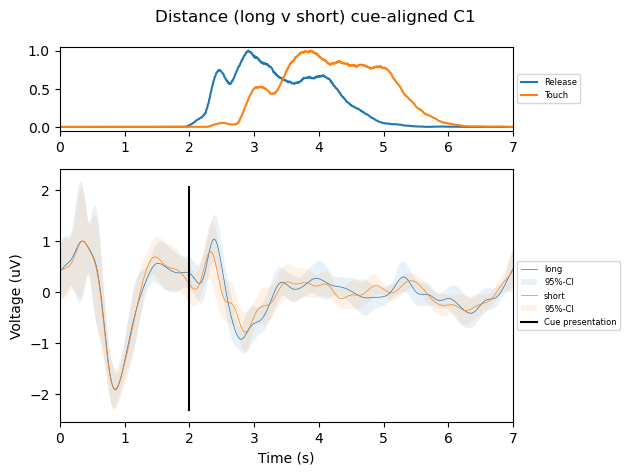

C:\Users\peter\Documents\Code\example_pipeline_mne\preprocessing_ptu.py:1230: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  fig = mne.concatenate_epochs(epochs_lst[i]).average().plot_topomap(times, ch_type='eeg',


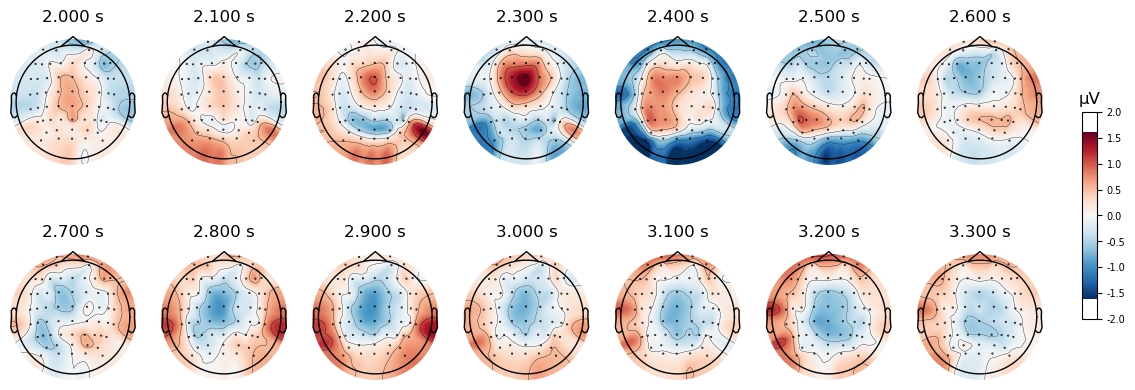

In [29]:
# Plot cue-aligned grand average:
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='epoched_cue_aligned', dst_fldr='temp_plots')

# Topoplot at distinct timepoints:
times_of_interest = list(np.arange(2.0,3.4,0.1))

prep.plot_grand_average(src=src_path, dst=dst_path, sbj_list=SUBJECTS, paradigm='paradigm', split=['long', 'short'], channel='C1')
prep.plot_topomaps(src=src_path, dst=dst_path, sbj_list=SUBJECTS, paradigm='paradigm', split=[''], times=times_of_interest, ncols=7, activity=False)

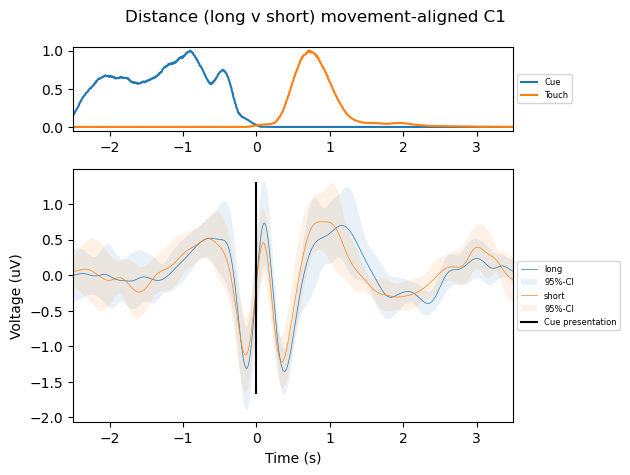

C:\Users\peter\Documents\Code\example_pipeline_mne\preprocessing_ptu.py:1230: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  fig = mne.concatenate_epochs(epochs_lst[i]).average().plot_topomap(times, ch_type='eeg',


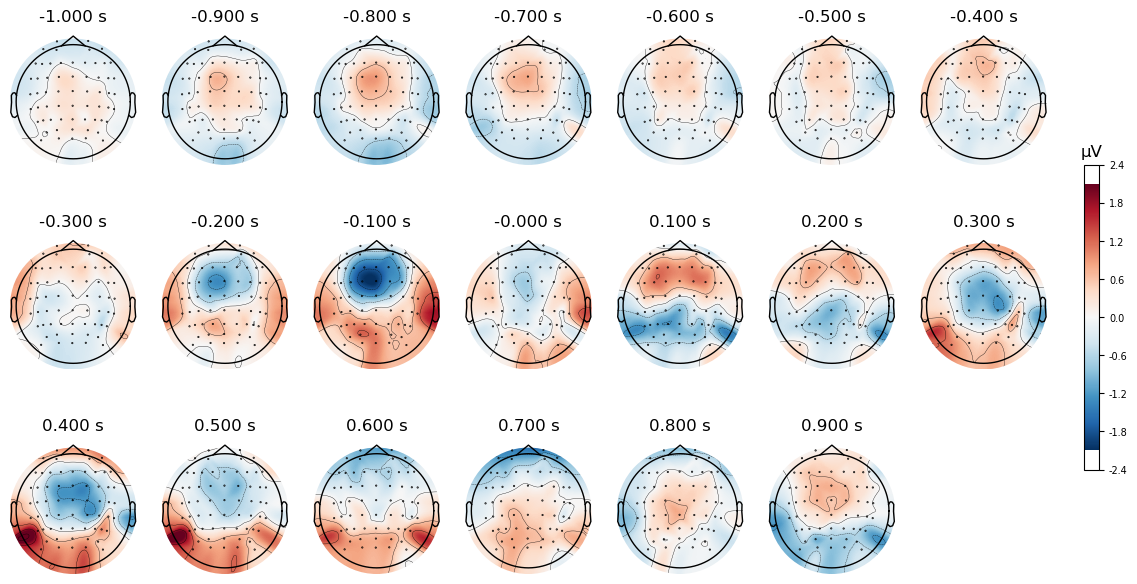

In [30]:
# Plot cue-aligned grand average:
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='epoched_movement_aligned', dst_fldr='temp_plots')

# Topoplot at distinct timepoints:
times_of_interest = list(np.arange(-1.0,1.0,0.1))

prep.plot_grand_average(src=src_path, dst=dst_path, sbj_list=SUBJECTS, paradigm='paradigm', split=['long', 'short'], channel='C1')
prep.plot_topomaps(src=src_path, dst=dst_path, sbj_list=SUBJECTS, paradigm='paradigm', split=[''], times=times_of_interest, ncols=7, activity=False)

## 12. Classification

The following cell performs a classification using shrinkage LDA (sLDA) which aims to separate the given classes. Three general classifiers were implemented, namely, a range classifier (2-class), a direction classifier (4-class) and a position classifier (5-class). The classification results are stored in a csv file and can be used for plotting. Have a look into this function to see how the features are selected and the classifier is set-up.

Possiblities to select are:
- condition: Type of classifier: 'distance', 'direction', 'direction-short', 'direction-long', 'position'
- n_timepoints: Number of timepoints to use as features
- loo: True/False wheter to use Leave-one-out crossvalidation or a 5-fold CV (may take very long if loo is True)

### 12.1. Cue-aligned

In [16]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=DATA_PATH, src_fldr='epoched_cue_aligned_resampled', dst_fldr='epoched_cue_aligned_resampled')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(tqdm(SUBJECTS)):
    #print(f'Classifying cue-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=6, loo=True)

    ### Direction
    # Classify the epochs for 1 timepoint:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=6, loo=True)

    ### Direction short
    # Classify the epochs for 1 timepoint:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=6, loo=True)

    ### Direction long
    # Classify the epochs for 1 timepoint:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=6, loo=True)

    ### Position
    # Classify the epochs for 1 timepoint:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    prep.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=6, loo=True)


print(f'Finished classifying, took me {round(time.time() - start)} seconds...')


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.45s/it]

Finished classifying, took me 94 seconds...


### 12.2. Movement-aligned

In [ ]:
# Get source and destination path + create destintation folder if it does not exist.
src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='epoched_movement_aligned_resampled', dst_fldr='epoched_movement_aligned_resampled')

# Iterate over each subject and extract the streams
start = time.time()
for i, subject in enumerate(tqdm(subjects)):
    #print(f'Classifying movement-aligned for subject {subject}')

    ### Distance
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='distance', n_timepoints=6, loo=True)

    ### Direction
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction', n_timepoints=6, loo=True)

    ### Direction short
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_short', n_timepoints=6, loo=True)

    ### Direction long
    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='direction_long', n_timepoints=6, loo=True)

    # Classify the epochs for 1 timepoint:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=1, loo=True)
    # Classify the epochs for 6 timepoints:
    clas.classify(src=src_path, dst=dst_path, sbj=subject, condition='position', n_timepoints=6, loo=True)


print(f'Finished classifiying, took me {round(time.time() - start)} seconds...')